In [1]:
import itertools
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import MeanShift

In [2]:
data = pd.read_csv('../data/processed/processed.csv')

In [3]:
data_rows = len(data)
scores = []
bandwidths = np.arange(0.40, 0.70, 0.01)


for bandwidth in bandwidths: 
    ms = MeanShift(bandwidth=bandwidth)
    prediction = ms.fit_predict(X=data)
    n_clusters = len(np.unique(prediction))
    
    if n_clusters != 1 and n_clusters != data_rows:
        sc = silhouette_score(data, prediction)
        db = davies_bouldin_score(data, prediction)
        ch = calinski_harabasz_score(data, prediction)
        scores.append((bandwidth, sc, db, ch, prediction,n_clusters))

In [4]:
tested_bandwidths, scs, dbs, chs, predictions, n_clusters = zip(*scores)
placings_per_alt = {}

for i in range(len(scores)):
    placings_per_alt[tested_bandwidths[i]] = {
        'bandwidth':tested_bandwidths[i],
        'silhouette coefficient': scs[i],
        'davies-bouldin index': dbs[i],
        'calinski-harabasz index': chs[i],
        'prediction': predictions[i],
        'clusters': n_clusters[i]
    }

sorted_by_max_sc = sorted(scores, key=lambda score: score[1], reverse=True)
sorted_by_min_db = sorted(scores, key=lambda score: score[2], reverse=False)
sorted_by_max_ch = sorted(scores, key=lambda score: score[3], reverse=True)

for index, score in enumerate(sorted_by_max_sc):
    placings_per_alt[score[0]]['max_sc'] = index

for index, score in enumerate(sorted_by_min_db):
    placings_per_alt[score[0]]['min_db'] = index

for index, score in enumerate(sorted_by_max_ch):
    placings_per_alt[score[0]]['max_ch'] = index

In [5]:
def overall_placing(score):
    alt = placings_per_alt[score[0]]
    return (alt['max_sc'] + alt['min_db'] + alt['max_ch']+3) / 3

sorted_scores_on_overall = sorted(scores, key=overall_placing, reverse=False)

for index, score in enumerate(sorted_scores_on_overall):
    placings_per_alt[score[0]]['overall'] = index


models = sorted(placings_per_alt.values(), key=lambda alt: alt['overall'], reverse=False)
models_in_tuples = [model.values() for model in models]


In [6]:
sorted_bandwidths, sorted_scs, sorted_dbs, sorted_chs, sorted_predictions, sorted_clusters, sorted_placing_sc, sorted_placing_db, sorted_placing_ch, sorted_overall = zip(*models_in_tuples)

In [7]:
def points_in_clusters(distribution):
    amount_of_points_in_cluster = {}
    for cluster_id in distribution:
        if cluster_id in amount_of_points_in_cluster:
            amount_of_points_in_cluster[cluster_id] += 1
        else:
            amount_of_points_in_cluster[cluster_id] = 1
    points_in_cluster_descending = sorted(list(amount_of_points_in_cluster.values()), reverse=True)
    return tuple(points_in_cluster_descending)

In [8]:
def print_info(i):
    print(
        f'{sorted_overall[i]:>2}. '
        f'Bandwidth: {sorted_bandwidths[i]:.2f}. '
        f'Scores: SC={sorted_scs[i]: 5.2f}, DB={sorted_dbs[i]: 5.2f}, CH={sorted_chs[i]: 7.2f}. '
        f'Clusters: {sorted_clusters[i]:>3}. Distribution: {str(points_in_clusters(sorted_predictions[i]))[:20]:<20}'
    )

In [9]:
top_amount = min(30,len(scores))

for i in range(top_amount):
    print_info(i)

 0. Bandwidth: 0.63. Scores: SC= 0.28, DB= 0.92, CH=  37.88. Clusters:   4. Distribution: (151, 54, 4, 1)     
 1. Bandwidth: 0.64. Scores: SC= 0.28, DB= 0.92, CH=  37.88. Clusters:   4. Distribution: (151, 54, 4, 1)     
 2. Bandwidth: 0.67. Scores: SC= 0.45, DB= 0.87, CH=   9.54. Clusters:   2. Distribution: (208, 2)            
 3. Bandwidth: 0.68. Scores: SC= 0.45, DB= 0.87, CH=   9.54. Clusters:   2. Distribution: (208, 2)            
 4. Bandwidth: 0.55. Scores: SC= 0.12, DB= 1.10, CH=  22.34. Clusters:  11. Distribution: (96, 82, 8, 8, 5, 3,
 5. Bandwidth: 0.62. Scores: SC= 0.17, DB= 1.33, CH=  25.98. Clusters:   6. Distribution: (152, 35, 9, 9, 4, 1
 6. Bandwidth: 0.58. Scores: SC= 0.12, DB= 1.10, CH=  22.95. Clusters:  10. Distribution: (109, 74, 9, 8, 2, 2
 7. Bandwidth: 0.69. Scores: SC= 0.45, DB= 0.87, CH=   9.54. Clusters:   2. Distribution: (208, 2)            
 8. Bandwidth: 0.56. Scores: SC= 0.14, DB= 1.14, CH=  23.61. Clusters:  10. Distribution: (97, 86, 8, 8, 3, 2,
 

In [10]:
def is_trivial(i):
    return (
        sorted_clusters[i] >= 208
        or points_in_clusters(sorted_predictions[i])[0] >= 208
        or len(points_in_clusters(sorted_predictions[i])) >= 100
    )

top_no_trivial = [i for i in range(len(sorted_overall)) if not is_trivial(i)][:top_amount]

for i in top_no_trivial:
    print_info(i)


 0. Bandwidth: 0.63. Scores: SC= 0.28, DB= 0.92, CH=  37.88. Clusters:   4. Distribution: (151, 54, 4, 1)     
 1. Bandwidth: 0.64. Scores: SC= 0.28, DB= 0.92, CH=  37.88. Clusters:   4. Distribution: (151, 54, 4, 1)     
 4. Bandwidth: 0.55. Scores: SC= 0.12, DB= 1.10, CH=  22.34. Clusters:  11. Distribution: (96, 82, 8, 8, 5, 3,
 5. Bandwidth: 0.62. Scores: SC= 0.17, DB= 1.33, CH=  25.98. Clusters:   6. Distribution: (152, 35, 9, 9, 4, 1
 6. Bandwidth: 0.58. Scores: SC= 0.12, DB= 1.10, CH=  22.95. Clusters:  10. Distribution: (109, 74, 9, 8, 2, 2
 8. Bandwidth: 0.56. Scores: SC= 0.14, DB= 1.14, CH=  23.61. Clusters:  10. Distribution: (97, 86, 8, 8, 3, 2,
 9. Bandwidth: 0.60. Scores: SC= 0.17, DB= 1.44, CH=  25.68. Clusters:   7. Distribution: (143, 30, 22, 7, 4, 
10. Bandwidth: 0.61. Scores: SC= 0.17, DB= 1.33, CH=  25.43. Clusters:   6. Distribution: (153, 34, 9, 9, 4, 1
11. Bandwidth: 0.54. Scores: SC= 0.11, DB= 1.07, CH=  19.55. Clusters:  13. Distribution: (98, 79, 8, 7, 5, 2,
1

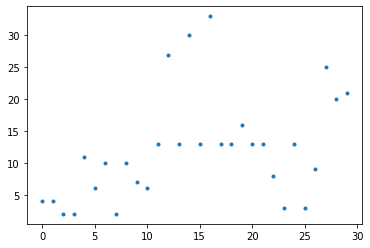

In [11]:
plt.plot(sorted_overall, sorted_clusters,'.')
plt.show()


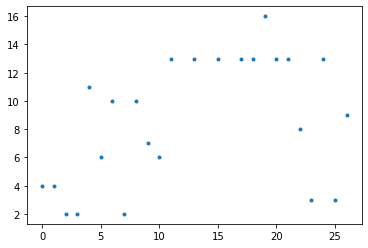

In [12]:
clusterings_under_20 = [(index, cluster_amount) for index, cluster_amount in enumerate(sorted_clusters) if cluster_amount < 20 ]
indexes_u20, cluster_amount_u20 = zip(*clusterings_under_20)

plt.plot(indexes_u20, cluster_amount_u20,'.')
plt.show()
